# Goal

This notebook checks model performance on a test set.

**With gratitude to**:
- https://github.com/mattiaspaul/OBELISK
-  https://github.com/kbressem/faimed3d/blob/main/examples/3d_segmentation.md

In [1]:
# DATALOADER PARAMS
bs          = 4
nepochs     = 30
num_workers = 4

# PREPROCESS (Isotropic, PadResize)
# iso       = 3
# maxs      = [87, 90, 90]

iso       = 2
maxs      = [130, 134, 134]

# Train:Valid:Test = 60:20:20
train_pct, valid_pct = .60, .20

#train_pct, valid_pct = 100/335.0, 20/335.0

test_pct = 1.0 - train_pct - valid_pct

def pct2int(pct, tot=335): return int(pct * tot)
print(f"Train/Valid/Test: {train_pct:0.2f} (n={pct2int(train_pct)}), {valid_pct:0.2f} (n={pct2int(valid_pct)}), {test_pct:0.2f} (n={pct2int(test_pct)})")

Train/Valid/Test: 0.60 (n=201), 0.20 (n=67), 0.20 (n=67)


In [2]:
# CHECK HARDWARE 

import os
import torch

gpu_count = torch.cuda.device_count()
cpu_count = os.cpu_count()
print("#GPU = {0:d}, #CPU = {1:d}".format(gpu_count, cpu_count))

#GPU = 2, #CPU = 40


# Paths

In [3]:
# Paths to (1) code (2) data (3) saved models
code_src    = "/gpfs/home/gologr01"
data_src    = "/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata"
model_src   = "/gpfs/data/oermannlab/private_data/DeepPit/saved_models"

# UMich 
# code src: "/home/labcomputer/Desktop/Rachel"
# data src: "../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/"

deepPit_src = f"{code_src}/DeepPit"
obelisk_src = f"{code_src}/OBELISK"
label_src   = f"{data_src}/samir_labels"
ABIDE_src   = f"{data_src}/ABIDE"

# print
print("Folders in data src: ", end=""); print(*os.listdir(data_src), sep=", ")
print("Folders in label src (data w labels): ", end=""); print(*os.listdir(label_src), sep=", ")
print("Folders in ABIDE src (data wo labels) ", end=""); print(*os.listdir(ABIDE_src), sep=", ")

Folders in data src: ICMB, ABVIB (1).zip, central.xnat.org, ADNI, PPMI, Oasis_long, samir_labels, ACRIN-FMISO-Brain, LGG-1p19qDeletion, REMBRANDT, AIBL, CPTAC-GBM, TCGA-GBM, TCGA-LGG, ABVIB, ABIDE, AIBL.zip
Folders in label src (data w labels): 50155-50212, 50313-50372, 50213-50312, 50373-50453, 50002-50153
Folders in ABIDE src (data wo labels) PAD, ABIDE_1, ABIDE


# Imports

In [4]:
# imports
from transforms import AddChannel, Iso, PadSz, MattAffineTfm, PiecewiseHistScaling
from helpers.metrics import dice_score, dice_loss, dice_ce_loss, log_cosh_dice_loss

# Utilities
import os
import sys
import time
import pickle
from pathlib import Path

# Input IO
import SimpleITK as sitk
import meshio

# Numpy and Pandas
import numpy as np
import pandas as pd
from pandas import DataFrame as DF

# Fastai + distributed training
from fastai import *
from fastai.torch_basics import *
from fastai.basics import *
from fastai.distributed import *

# PyTorch
from torchvision.models.video import r3d_18
from fastai.callback.all import SaveModelCallback
from torch import nn

# Obelisk
sys.path.append(deepPit_src)
sys.path.append(obelisk_src)

# OBELISK
from utils import *
from models import obelisk_visceral, obeliskhybrid_visceral

# 3D extension to FastAI
# from faimed3d.all import *

# Helper functions
from helpers.preprocess import get_data_dict_n4, paths2objs, folder2objs, seg2mask, mask2bbox, print_bbox, get_bbox_size, print_bbox_size
from helpers.general import sitk2np, np2sitk, print_sitk_info, round_tuple, lrange, lmap, get_roi_range, numbers2groups
from helpers.viz import viz_axis, viz_bbox
#from helpers.nyul_udupa import piecewise_hist

# Data

In [5]:
model_fns = os.listdir(model_src)
print(*[model_fn for model_fn in model_fns if model_fn.endswith(".pth")], sep="\n")

iso_2mm_pad_130_134_134_bs_4_test_sz_67_epochs_30_time_Mon Jun 28 16:10:23 2021.pth
iso_2mm_pad_130_134_134_bs_4_test_sz_67_epochs_30_time_Mon Jun 28 18:00:05 2021.pth
iso_3mm_pad_87_90_90_bs_20_test_sz_67_epochs_30_time_Mon Jun 28 10:34:06 2021.pth
iso_3mm_pad_87_90_90_bs_20_test_sz_67_epochs_30_time_Thu Jun 24 14:21:03 2021.pth
iso_2mm_pad_130_134_134_bs_4_test_sz_67_epochs_30_time_Mon Jun 28 15:31:38 2021.pth
iso_2mm_pad_130_134_134_bs_5_test_sz_67_epochs_30_time_Mon Jun 28 11:58:20 2021.pth
iso_2mm_pad_130_134_134_bs_4_test_sz_67_epochs_30_time_Mon Jun 28 12:16:16 2021.pth
iso_2mm_pad_130_134_134_bs_4_test_sz_67_epochs_30_time_Mon Jun 28 17:33:56 2021.pth


In [6]:
model_fn = "iso_2mm_pad_130_134_134_bs_4_test_sz_67_epochs_30_time_Mon Jun 28 18:00:05 2021.pth"
test_fn  = model_fn[:-4] + "_test_items.pkl"

# get parameters

def get_param(fn, prefix, suffix):
    start = fn.index(prefix)
    end   = fn.index(suffix)
    ints = fn[start+len(prefix):end].split("_")
    if len(ints) == 1: return int(ints[0])
    return [int(x) for x in ints]

iso_sz  = get_param(model_fn, "iso_", "mm")
maxs    = get_param(model_fn, "pad_", "_bs")
bs      = get_param(model_fn, "bs_", "_test")
nepochs = get_param(model_fn, "epochs_", "_time")

# get test items
with open(f"{model_src}/{test_fn}", "rb") as input_file:
    test_items = pickle.load(input_file)
    
# get all items
data = {}
folders = os.listdir(label_src)
for folder in folders: data.update(get_data_dict_n4(f"{label_src}/{folder}"))
items = list(data.values())

# print
print(f"Iso: {iso_sz}. PadResize to: {maxs}. bs = {bs}. nepochs = {nepochs}.")
print(f"Num test items: {len(test_items)}")
print(f"Num items: {len(items)}")

Iso: 2. PadResize to: [130, 134, 134]. bs = 4. nepochs = 30.
Num test items: 67
Num items: 335


# Dataloaders

In [7]:
# load standard scale
save_loc = f"{deepPit_src}/saved_metadata/"
standard_scale = torch.load(f"{save_loc}/nyul_udupa_standard_scale_335.pt")
percs          = torch.load(f"{save_loc}/nyul_udupa_percs_335.pt")

In [8]:
# time it
start = time.time()

# splits
#splits = RandomSplitter(seed=42)(subset)
#print(f"Training: {len(splits[0])}, Valid: {len(splits[1])}")

# tfms
item_tfms  = [Iso(2), PadSz(maxs), PiecewiseHistScaling(landmark_percs=percs, standard_scale=standard_scale)]
batch_tfms = [AddChannel()]

# tls
tls = TfmdLists(test_items, item_tfms)

# dls
dls = tls.dataloaders(bs=bs, after_batch=batch_tfms, num_workers=num_workers)

# GPU
dls = dls.cuda()

# end timer
elapsed = time.time() - start
print(f"Elapsed time: {elapsed} s for {len(test_items)} items")

# test get one batch
b = dls.one_batch()
print(type(b), b[0].shape, b[1].shape)
print(f"bs = {bs}, n_train = {len(dls.train)}, n_valid = {len(dls.valid)}, n_test_items = {len(test_items)}, n = {len(items)}")

Elapsed time: 13.93366003036499 s for 67 items
<class 'tuple'> torch.Size([4, 1, 130, 134, 134]) torch.Size([4, 1, 130, 134, 134])
bs = 4, n_train = 16, n_valid = 0, n_test_items = 67, n = 335


# Metric

Linear combination of Dice and Cross Entropy

# Learner

In [9]:
import gc
gc.collect()

46

In [10]:
full_res = maxs

learn = Learner(dls=dls, \
                model=obeliskhybrid_visceral(num_labels=2, full_res=full_res), \
                loss_func= log_cosh_dice_loss, #loss, \
                metrics = dice_score)

# load model fname w/o .pth extension
learn.load(f"{model_src}/{model_fn[:-4]}")

In [11]:
# all predictions, 67 items, 4 workers, 15sec
start = time.time()
predictions, targets = learn.get_preds(ds_idx=0)
elapsed = time.time() - start

print(f"Elapsed: {elapsed:0.2f} s for {len(test_items)} items.")

Elapsed: 14.18 s for 67 items.


In [12]:
print(predictions.shape, targets.shape)

torch.Size([67, 2, 130, 134, 134]) torch.Size([67, 1, 130, 134, 134])


In [13]:
targets[0].shape, predictions[0].shape

(torch.Size([1, 130, 134, 134]), torch.Size([2, 130, 134, 134]))

In [14]:
xb,yb = learn.dls.one_batch()
init_loss = learn.loss_func(learn.model(xb), yb)
print(init_loss)

a = learn.model(xb)
print(a.shape)

overall_dice = dice_score(predictions, targets)
print(overall_dice)

tensor(0.0109, device='cuda:0', grad_fn=<LogBackward>)
torch.Size([4, 2, 130, 134, 134])
tensor(0.8474)


# Test set: Prediction Dice Distribution

In [15]:
indiv_dices = [dice_score(predictions[i].unsqueeze(0), targets[i].unsqueeze(0)) for i in range(len(targets))]

{'whiskers': [<matplotlib.lines.Line2D at 0x7faaee6535f8>,
 'caps': [<matplotlib.lines.Line2D at 0x7faaee653b38>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faaee62d748>],
 'medians': [<matplotlib.lines.Line2D at 0x7faaee5e5128>],
 'fliers': [<matplotlib.lines.Line2D at 0x7faaee5e5400>],
 'means': []}

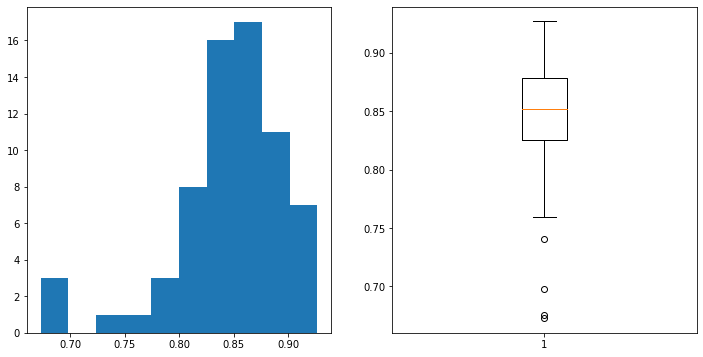

In [16]:
np_indiv_dices = np.array([t.item() for t in indiv_dices])
fig1, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax0.hist(np_indiv_dices, bins="auto")
ax1.boxplot(np_indiv_dices)

# $\Delta$ bbox

In [17]:
print(predictions.shape, predictions[0].shape, targets[0].shape, torch.argmax(predictions[0], dim=0).shape)

torch.Size([67, 2, 130, 134, 134]) torch.Size([2, 130, 134, 134]) torch.Size([1, 130, 134, 134]) torch.Size([130, 134, 134])


In [18]:
gt_bboxs   = [mask2bbox(np.asarray(targets[i].squeeze()))                for i in range(len(targets))]
pred_bboxs = [mask2bbox(np.asarray(torch.argmax(predictions[i], dim=0))) for i in range(len(predictions))]

In [19]:
print(gt_bboxs[0], pred_bboxs[0])

(58, 75, 60, 75, 57, 67) (57, 75, 60, 75, 55, 67)


In [20]:
# compare sizes
def get_bbox_size(imin, imax, jmin, jmax, kmin, kmax): return imax - imin, jmax-jmin, kmax-kmin
gt_bbox_szs   = [get_bbox_size(*gt) for gt in gt_bboxs]
pred_bbox_szs = [get_bbox_size(*pr) for pr in pred_bboxs]

In [21]:
import pandas as pd
gt_df = pd.DataFrame(gt_bbox_szs, columns =['i', 'j', 'k'])
pred_df = pd.DataFrame(pred_bbox_szs, columns =['i', 'j', 'k'])

In [22]:
gt_bbox_szs

[(17, 15, 10),
 (20, 16, 11),
 (15, 11, 9),
 (19, 14, 12),
 (16, 16, 12),
 (20, 18, 12),
 (17, 15, 12),
 (19, 16, 11),
 (12, 12, 11),
 (15, 13, 10),
 (14, 15, 11),
 (16, 16, 9),
 (20, 14, 11),
 (16, 13, 12),
 (16, 17, 11),
 (14, 13, 10),
 (14, 14, 10),
 (21, 15, 12),
 (17, 17, 12),
 (17, 15, 12),
 (19, 13, 11),
 (16, 14, 12),
 (18, 14, 11),
 (15, 15, 9),
 (18, 14, 8),
 (16, 13, 10),
 (17, 16, 13),
 (16, 13, 10),
 (19, 14, 10),
 (16, 16, 10),
 (17, 14, 11),
 (19, 16, 10),
 (16, 13, 9),
 (17, 12, 9),
 (16, 15, 9),
 (18, 15, 12),
 (16, 13, 10),
 (17, 14, 8),
 (18, 15, 10),
 (18, 18, 11),
 (17, 13, 11),
 (16, 11, 10),
 (18, 13, 11),
 (15, 13, 10),
 (17, 13, 10),
 (16, 15, 14),
 (17, 15, 11),
 (19, 15, 11),
 (13, 14, 7),
 (17, 13, 13),
 (17, 12, 9),
 (17, 14, 11),
 (16, 15, 13),
 (17, 15, 10),
 (18, 15, 13),
 (16, 15, 12),
 (17, 14, 11),
 (18, 13, 8),
 (18, 15, 13),
 (16, 12, 10),
 (15, 13, 12),
 (17, 15, 13),
 (17, 15, 12),
 (15, 12, 12),
 (17, 15, 9),
 (17, 16, 11),
 (19, 14, 9)]

In [23]:
pred_bbox_szs

[(18, 15, 12),
 (21, 16, 12),
 (20, 17, 12),
 (18, 16, 13),
 (20, 18, 14),
 (21, 18, 14),
 (22, 49, 29),
 (19, 16, 12),
 (16, 15, 12),
 (16, 17, 12),
 (17, 16, 12),
 (19, 16, 12),
 (20, 17, 13),
 (19, 15, 12),
 (18, 17, 11),
 (15, 19, 14),
 (19, 18, 14),
 (20, 17, 14),
 (20, 18, 15),
 (18, 15, 12),
 (18, 16, 13),
 (19, 17, 13),
 (19, 16, 14),
 (18, 16, 11),
 (18, 16, 12),
 (18, 16, 12),
 (19, 15, 12),
 (16, 15, 12),
 (19, 16, 12),
 (18, 15, 12),
 (18, 17, 13),
 (20, 16, 11),
 (18, 14, 11),
 (18, 16, 13),
 (17, 17, 11),
 (18, 17, 12),
 (17, 17, 12),
 (18, 16, 12),
 (20, 16, 12),
 (37, 37, 13),
 (19, 17, 13),
 (19, 15, 13),
 (16, 17, 13),
 (15, 17, 11),
 (17, 15, 13),
 (18, 18, 14),
 (25, 20, 13),
 (18, 15, 15),
 (16, 16, 11),
 (17, 15, 11),
 (17, 14, 11),
 (18, 16, 14),
 (17, 18, 13),
 (17, 17, 12),
 (21, 17, 14),
 (15, 15, 11),
 (46, 26, 13),
 (20, 16, 11),
 (18, 15, 13),
 (17, 15, 13),
 (18, 15, 14),
 (18, 22, 25),
 (18, 15, 13),
 (18, 16, 14),
 (18, 15, 11),
 (19, 16, 13),
 (19, 16, 

<AxesSubplot:>

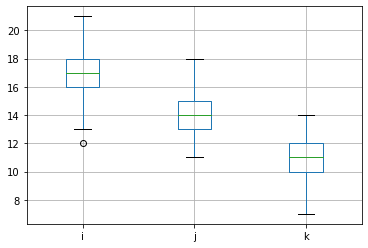

In [24]:
gt_df.boxplot(column=['i', 'j', 'k'])

<AxesSubplot:>

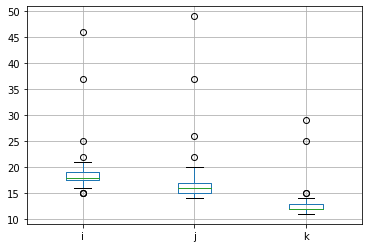

In [25]:
pred_df.boxplot(column=['i', 'j', 'k'])

array([[<AxesSubplot:title={'center':'i'}>,
        <AxesSubplot:title={'center':'j'}>],
       [<AxesSubplot:title={'center':'k'}>, <AxesSubplot:>]], dtype=object)

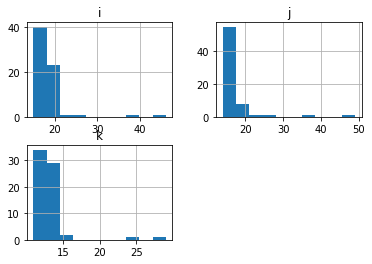

In [26]:
pred_df.hist(column=['i', 'j', 'k'])

array([[<AxesSubplot:title={'center':'i'}>,
        <AxesSubplot:title={'center':'j'}>],
       [<AxesSubplot:title={'center':'k'}>, <AxesSubplot:>]], dtype=object)

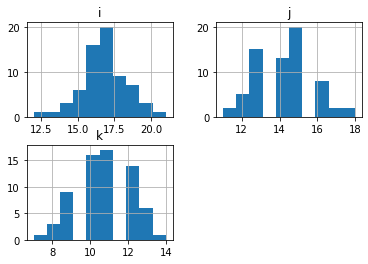

In [27]:
gt_df.hist(column=['i', 'j', 'k'])

In [28]:
def bbox_missing(gt_bbox, pred_bbox):
    # for i_min: missing if gt < pred
    # for i_max: missing if gt > pred
    mins = [max(pred_bbox[i] - gt_bbox[i], 0) for i in (0, 2, 4)]
    maxs = [max(gt_bbox[i] - pred_bbox[i], 0) for i in (1, 3, 5)]
    missing = [x for t in zip(mins, maxs) for x in t]
    return missing

In [29]:
# test
print(bbox_missing((0,1,2,3,4,5), (0,2,2,3,4,5)))
print(bbox_missing((0,1,2,3,4,5), (1,2,2,3,4,5)))
print(bbox_missing((0,1,2,3,4,5), (-2,2,2,3,4,5)))

[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]


In [30]:
missings = [bbox_missing(gt, pred) for gt, pred in zip(gt_bboxs, pred_bboxs)]

In [31]:
missings_df = pd.DataFrame(missings, columns =['imin', 'imax', 'jmin', 'jmax', 'kmin', 'kmax'])

array([[<AxesSubplot:title={'center':'imin'}>,
        <AxesSubplot:title={'center':'imax'}>],
       [<AxesSubplot:title={'center':'jmin'}>,
        <AxesSubplot:title={'center':'jmax'}>],
       [<AxesSubplot:title={'center':'kmin'}>,
        <AxesSubplot:title={'center':'kmax'}>]], dtype=object)

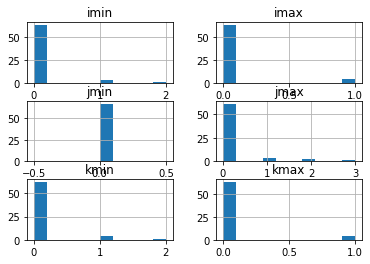

In [32]:
missings_df.hist(column=['imin', 'imax', 'jmin', 'jmax', 'kmin', 'kmax'])

<AxesSubplot:>

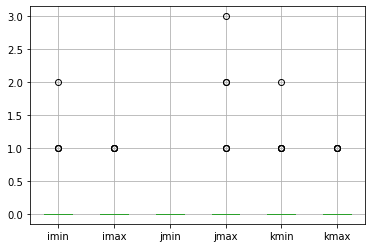

In [33]:
missings_df.boxplot(column=['imin', 'imax', 'jmin', 'jmax', 'kmin', 'kmax'])

In [34]:
for col in ['imin', 'imax', 'jmin', 'jmax', 'kmin', 'kmax']:
    nonzero = [v for v in missings_df[col].values if v != 0]
    max_nonzero = max(nonzero) if len(nonzero) > 0 else "NA"
    print(f"{col}: n = {len(nonzero)}, max diff = {max_nonzero}")

imin: n = 4, max diff = 2
imax: n = 4, max diff = 1
jmin: n = 0, max diff = NA
jmax: n = 6, max diff = 3
kmin: n = 5, max diff = 2
kmax: n = 4, max diff = 1


# Viz worst

In [35]:
worst_idx = np.argmin(np_indiv_dices)
print("Worst: ", worst_idx, "Dice: ", np_indiv_dices[worst_idx])

Worst:  8 Dice:  0.6730337142944336


In [36]:
pred, target = predictions[worst_idx], targets[worst_idx].squeeze()
#pred = torch.argmax(predictions[worst_idx], dim=0)
print(pred.shape, target.shape, dls.train_ds[worst_idx][0].shape)
print(np.array_equal(dls.train_ds[worst_idx][1], target))

torch.Size([2, 130, 134, 134]) torch.Size([130, 134, 134]) torch.Size([130, 134, 134])
True


In [37]:
mr = dls.train_ds[worst_idx][0]
# print(mr.shape)
# print(mask2bbox(np.asarray(mr)))

In [38]:
print(mask2bbox(np.asarray(targets[worst_idx].squeeze())))
print(mask2bbox(np.asarray(target)))

(59, 71, 62, 74, 63, 74)
(59, 71, 62, 74, 63, 74)


# Viz

In [39]:
from helpers.preprocess import print_bbox
from helpers.viz import bbox_union

In [40]:
# Viz
def viz_bbox(mr, seg, pred):
#     mr, seg = learn.dls.train_ds[idx] 
#     pred = learn.predict(test_items[idx])[0]
    
    # dice (add B dimension)
#     dice = dice_score(pred.unsqueeze(0), seg.unsqueeze(0).unsqueeze(0))
#     print(f"Dice: {dice:0.4f}")
    
    # convert pred to mask
    pred_mk   = torch.argmax(pred, dim=0)
    pred_bbox = mask2bbox(np.array(pred_mk))

    mr, seg = np.array(mr), np.array(seg)
    gt_bbox = mask2bbox(seg)
    
    # union bbox
    bbox = bbox_union(gt_bbox, pred_bbox)
    
    # print bbox
    print("Pred: "); print_bbox(*pred_bbox)
    print("GT: "); print_bbox(*gt_bbox)
    print("Union: "); print_bbox(*bbox)
          
    # viz
    viz_axis(np_arr = mr, \
            bin_mask_arr   = seg,     color1 = "yellow",  alpha1=0.3, \
            bin_mask_arr2  = pred_mk, color2 = "magenta", alpha2=0.3, \
            slices=lrange(*bbox[0:2]), fixed_axis=0, \
            axis_fn = np.rot90, \
            title   = "Axis 0", \

            np_arr_b = mr, \
            bin_mask_arr_b   = seg,     color1_b = "yellow",  alpha1_b=0.3, \
            bin_mask_arr2_b  = pred_mk, color2_b = "magenta", alpha2_b=0.3, \
            slices_b = lrange(*bbox[2:4]), fixed_axis_b=1, \
            title_b  = "Axis 1", \

            np_arr_c = mr, \
            bin_mask_arr_c   = seg,     color1_c = "yellow",  alpha1_c=0.3, \
            bin_mask_arr2_c  = pred_mk, color2_c = "magenta", alpha2_c=0.3, \
            slices_c = lrange(*bbox[4:6]), fixed_axis_c=2, \
            title_c = "Axis 2", \
  
        ncols = 5, hspace=0.3, fig_mult=2)

In [41]:
gt_bboxs[worst_idx], pred_bboxs[worst_idx]

((59, 71, 62, 74, 63, 74), (57, 73, 61, 76, 61, 73))

Pred: 
Bbox coords: (57, 61, 61) to (73, 76, 73). Size: 16, 15, 12.
Bounding box coord: from location (61, 61) of slice 57 to location (76, 73) of slice 73.
GT: 
Bbox coords: (59, 62, 63) to (71, 74, 74). Size: 12, 12, 11.
Bounding box coord: from location (62, 63) of slice 59 to location (74, 74) of slice 71.
Union: 
Bbox coords: (57, 61, 61) to (73, 76, 74). Size: 16, 15, 13.
Bounding box coord: from location (61, 61) of slice 57 to location (76, 74) of slice 73.


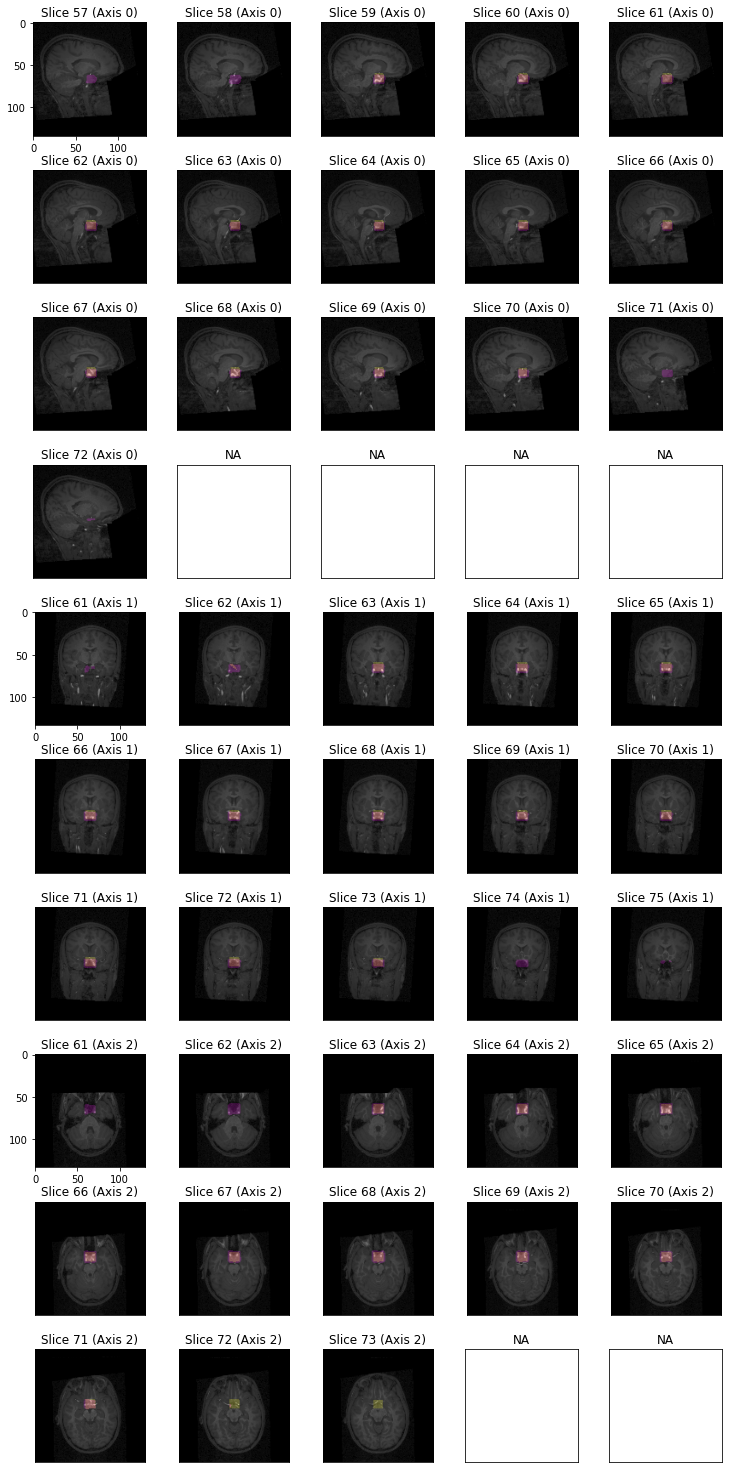

In [42]:
viz_bbox(mr, target, pred)

In [91]:
arr = torch.Tensor([[[1,2,3],[4,5,6]]])
print(arr)
print(arr.shape)

new_sz = (6,7,6)
# orig size = 1x2x3
# new size = 2,3

# Pads that were used
pad = [x-y for x,y in zip(new_sz, arr.shape)]
pad = [a for amt in pad for a in (amt//2, amt-amt//2)]
pad.reverse()
        
arr2 = F.pad(arr, pad, mode='constant', value=0)

print(arr.shape, arr2.shape)

tensor([[[1., 2., 3.],
         [4., 5., 6.]]])
torch.Size([1, 2, 3])
torch.Size([1, 2, 3]) torch.Size([6, 7, 6])


In [92]:
print(pad)

[2, 1, 3, 2, 3, 2]


In [93]:
# Reverse the padding
a,b,c,d,e,f            = pad
shape0, shape1, shape2 = arr2.shape
print(shape0, shape1)
arr3 = arr2[e:shape0-f, c:shape1-d, a:shape2-b]

6 7


In [95]:
print(np.array_equal(arr, arr3))
print(arr)
print(arr2)
print(arr3)

True
tensor([[[1., 2., 3.],
         [4., 5., 6.]]])
tensor([[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 2., 3., 0.],
         [0., 0., 4., 5., 6., 0.],
         [0., 0., 0., 0., 0., 0

In [43]:
viz_bbox(0)

TypeError: viz_bbox() missing 2 required positional arguments: 'seg' and 'pred'

In [ ]:
# 30 sec for 67 test items (2 CPU workers)
learn.validate(ds_idx=0)

# Resize Pred

In [ ]:
item_tfms

In [ ]:
len(predictions)

In [ ]:
len(test_items), test_items[0]

In [51]:
# reverse- PadSz Tfm

In [146]:
torch.Tensor((1,2,3))

tensor([1., 2., 3.])

In [188]:
# pad to new size
class ReverseTfm(ItemTransform):
    def __init__(self, iso_sp, const_sz):
        self.iso_sp   = iso_sz
        self.const_sz = const_sz
    
    def encodes(self, item):
        
        # decode item
        pred, im_path = item
        
        # Get shape post-Iso
        mr = sitk.ReadImage(im_path, sitk.sitkFloat32)

        # iso resize
        orig_sp = mr.GetSpacing()
        orig_sz = mr.GetSize()
        iso_sz = [int(round(osz*ospc/self.iso_sp)) for osz,ospc in zip(orig_sz, orig_sp)]
        
        # Pads used to go from iso_sz => const_sz
        pad = [x-y for x,y in zip(self.const_sz, iso_sz)]
        pad = [a for amt in pad for a in (amt//2, amt-amt//2)]
        pad.reverse()
        
        # Undo pad: const_sz => iso_sz
        shape0, shape1, shape2 = pred.shape
        a,b,c,d,e,f            = pad
        pred_no_pad = pred[e:shape0-f, c:shape1-d, a:shape2-b]

        # Undo iso (add batch dim for interpolate)
        while pred_no_pad.ndim < 5: 
            pred_no_pad = pred_no_pad.unsqueeze(0)
            
        return F.interpolate(pred_no_pad.float(), size = orig_sz, mode = 'nearest').squeeze().long()


In [189]:
pred = predictions[0]
pred_mk   = torch.argmax(pred, dim=0)
nii = test_items[0][0]

print(pred_mk.shape, nii, sep="\n")

torch.Size([130, 134, 134])
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50213-50312/50242/MP-RAGE/2000-01-01_00_00_00.0/S166097/ABIDE_50242_MRI_MP-RAGE_br_raw_20120905093536169_S166097_I330276_corrected_n4.nii


In [190]:
RTfm = ReverseTfm(iso_sp = 2, const_sz = [130, 134, 134])

In [191]:
rev_pred = RTfm((pred_mk, nii))

In [192]:
rev_pred.shape

torch.Size([160, 256, 256])

In [193]:
im_path, segm_path = test_items[0]
orig_mk = torch.load(f"{str(Path(segm_path).parent)}/seg.pt").float()

In [194]:
orig_mk.shape

torch.Size([160, 256, 256])

In [196]:
print(mask2bbox(np.asarray(orig_mk)))
print(mask2bbox(np.asarray(rev_pred)))

(65, 99, 114, 143, 108, 127)
(64, 100, 114, 144, 104, 128)


# Predict unlabelled

In [13]:
ds = "ABIDE"
print("Folders in ABIDE src (data wo labels) ", end=""); print(*os.listdir(ABIDE_src), sep=", ")

# load ABIDE files
with open(f"{deepPit_src}/saved_metadata/{ds}.txt", "rb") as input_file:
    ABIDE_fns = pickle.load(input_file)
    
# change prefix path
def change_src(overlap, s, new_src):
    return new_src + s[s.index(overlap) + len(overlap):]

ABIDE_fns = [change_src("PitMRdata", s, data_src) for s in ABIDE_fns]

# ABIDE ABIDE
ABIDE_ABIDE_fns = [fn for fn in ABIDE_fns if fn.startswith(f"{data_src}/ABIDE/ABIDE")]
print(f"ABIDE: {len(ABIDE_fns)} vs {len(ABIDE_ABIDE_fns)} files for ABIDE/ABIDE.")

# Get unlabelled files
def get_folder_name(s): 
    return re.search('\/([0-9]{5})\/', s).group(1)

ABIDE_folders = [get_folder_name(s) for s in ABIDE_ABIDE_fns]
labelled_folders = [child for folder in os.listdir(label_src) for child in os.listdir(f"{label_src}/{folder}")]
unlabelled_fns = [fn for fn in ABIDE_ABIDE_fns if get_folder_name(fn) not in labelled_folders]

# filter to exclude Matched_bandwidth_hires?
print(*unlabelled_fns[0:10], sep="\n")
print(os.listdir(unlabelled_fns[0])), print(os.listdir(unlabelled_fns[1]))

# unlabelled .nii files
unlabelled_items = [f"{fn}/{os.listdir(fn)[0]}" for fn in unlabelled_fns if "MP-RAGE" in fn]
print(len(unlabelled_items))

#unlabelled_folders = [folder for folder in ABIDE_folders if folder not in labelled_folders]
#print(f"Unlabelled_folders: {len(unlabelled_folders)}")

Folders in ABIDE src (data wo labels) PAD, ABIDE_1, ABIDE
ABIDE: 1160 vs 1157 files for ABIDE/ABIDE.
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/51236/Matched_Bandwidth_Hires/2000-01-01_00_00_00.0/S162786
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/51236/MP-RAGE/2000-01-01_00_00_00.0/S164617
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/51253/Matched_Bandwidth_Hires/2000-01-01_00_00_00.0/S162787
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/51253/MP-RAGE/2000-01-01_00_00_00.0/S164659
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/51233/Matched_Bandwidth_Hires/2000-01-01_00_00_00.0/S162788
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/51249/Matched_Bandwidth_Hires/2000-01-01_00_00_00.0/S162789
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/51249/MP-RAGE/2000-01-01_00_00_00.0/S164442
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/51210/M

In [100]:
class IsoTestSet(Transform):
    
    def __init__(self, new_sp = 3):
        self.new_sp = new_sp
        
    def encodes(self, x):
        # get sitk objs
        im_path = x
        mr = sitk.ReadImage(im_path, sitk.sitkFloat32)
        im = torch.transpose(torch.tensor(sitk.GetArrayFromImage(mr)), 0, 2)
       
        # resize so isotropic spacing
        orig_sp = mr.GetSpacing()
        orig_sz = mr.GetSize()
        new_sz = [int(round(osz*ospc/self.new_sp)) for osz,ospc in zip(orig_sz, orig_sp)]

        while im.ndim < 5: 
            im = im.unsqueeze(0)

        return F.interpolate(im, size = new_sz, mode = 'trilinear', align_corners=False).squeeze()
    
class Unsqueeze(Transform):
    def encodes(self, x):
        return x.unsqueeze(1) #.unsqueeze(0)

In [137]:
print(test_items[0]) 
print(unlabelled_items[0])

('/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50406/MP-RAGE/2000-01-01_00_00_00.0/S164885/ABIDE_50406_MRI_MP-RAGE_br_raw_20120830190936945_S164885_I328895.nii', '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50406/seg.pt')
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/51236/MP-RAGE/2000-01-01_00_00_00.0/S164617/ABIDE_51236_MRI_MP-RAGE_br_raw_20120830172549161_S164617_I328625.nii


In [142]:
# test DLs (no labelled segm obj)

unlabelled_items_subset = unlabelled_items[0:30]
unlabelled_items_subset = [(a,a) for a in unlabelled_items_subset]

unlbl_tfms = [IsoTestSet(3), PadSz(maxs)]
unlbl_tls = TfmdLists(unlabelled_items_subset, unlbl_tfms)
unlbl_dls = unlbl_tls.dataloaders(bs=bs, after_batch=AddChannel(), num_workers=num_workers)

# e

# unlbl_tfms = [IsoTestSet(3), PadSz(maxs)]
# unlbl_dl = TfmdDL(Datasets(unlabelled_items_subset), \
#                   after_item=unlbl_tfms, \
#                   after_batch=AddChannel(), \
#                   bs=bs, num_workers=num_workers)

# #dl = TfmdDL(Datasets(torch.arange(50), tfms = [L(), [_Add1()]]))
# unlbl_dls = DataLoaders(unlbl_dl, unlbl_dl)

# tls       = TfmdLists(unlabelled_items, test_tfms)
# test_dls = tls.dataloaders(bs=bs, after_batch=AddChannel(), num_workers=num_workers)

# test get one batch
b = unlbl_dls.one_batch()
print(type(b), len(b), b[0].shape, b[1].shape)
print(len(unlbl_dls.train_ds), len(unlbl_dls.valid_ds))

<class 'tuple'> 2 torch.Size([20, 1, 87, 90, 90]) torch.Size([20, 1, 87, 90, 90])
30 0


In [145]:
# all predictions, 36

full_res = maxs

unlbl_learn = Learner(dls=unlbl_dls, \
                model=obeliskhybrid_visceral(num_labels=2, full_res=full_res), \
                loss_func= loss, \
                metrics = dice_score)

# load model fname w/o .pth extension
unlbl_learn.load(f"{model_src}/{model_fn[:-4]}")

In [147]:
learn.predict??

In [146]:
is_cat,_,probs = unlbl_learn.predict(unlabelled_items_subset[0])

RuntimeError: expected scalar type Long but found Float

In [116]:
learn.predict()

In [153]:
unlbl_learn.get_preds??

In [155]:
unlbl_predictions = unlbl_learn.get_preds(dl=unlbl_dl)[0]
print(unlbl_predictions.shape)

In [165]:
# Viz

def viz_bbox_unlbl(idx):
    mr = unlbl_learn.dls.train_ds[idx][0] 
    pred = unlbl_predictions[idx]
    
    # convert pred to mask
    pred_mk   = torch.argmax(pred, dim=0)
    pred_bbox = mask2bbox(np.array(pred_mk))

    mr, pred_mk = np.array(mr), np.array(pred_mk)
    
    # print bbox
    print("Pred: "); print_bbox(*pred_bbox)
 
    # viz
    viz_axis(np_arr = mr, \
            bin_mask_arr   = pred_mk,     color1 = "yellow",  alpha1=0.3, \
            slices=lrange(*pred_bbox[0:2]), fixed_axis=0, \
            axis_fn = np.rot90, \
            title   = "Axis 0", \

            np_arr_b = mr, \
            bin_mask_arr_b   = pred_mk,     color1_b = "yellow",  alpha1_b=0.3, \
            slices_b = lrange(*pred_bbox[2:4]), fixed_axis_b=1, \
            title_b  = "Axis 1", \

            np_arr_c = mr, \
            bin_mask_arr_c   = pred_mk,     color1_c = "yellow",  alpha1_c=0.3, \
            slices_c = lrange(*pred_bbox[4:6]), fixed_axis_c=2, \
            title_c = "Axis 2", \
  
        ncols = 5, hspace=0.3, fig_mult=2)


Pred: 
Bbox coords: (38, 47, 44) to (52, 61, 52). Size: 14, 14, 8.
Bounding box coord: from location (47, 44) of slice 38 to location (61, 52) of slice 52.


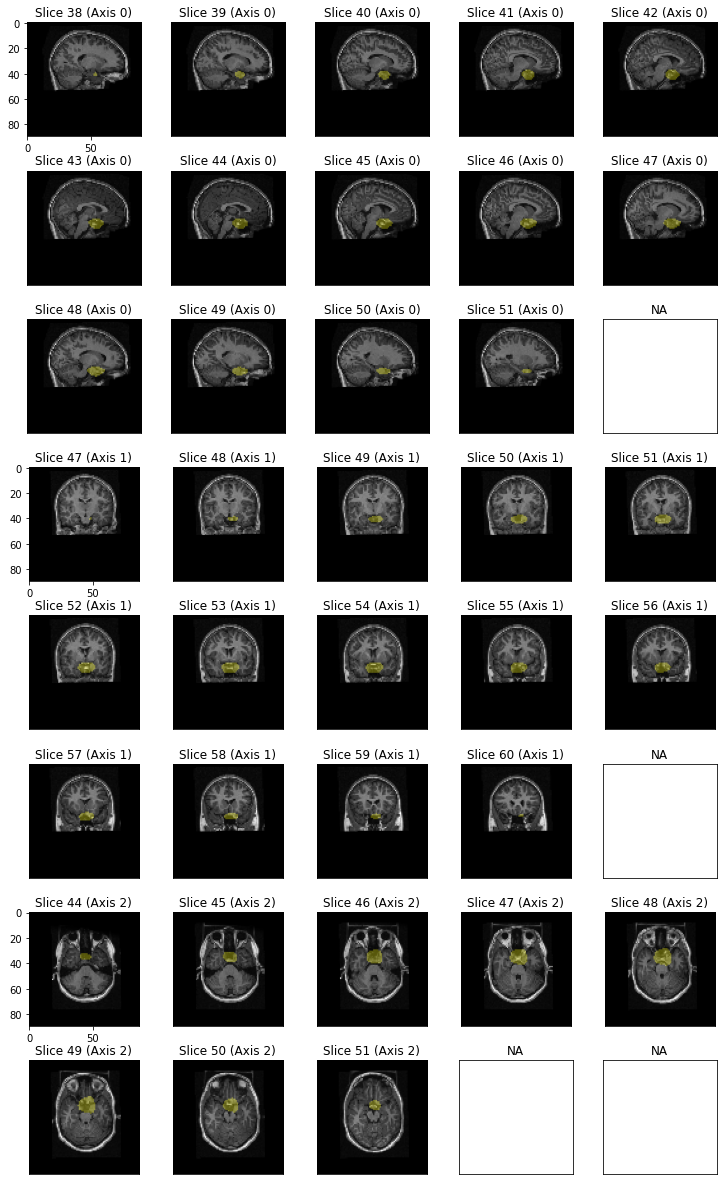

In [166]:
viz_bbox_unlbl(0)